# Test Data from Palmer

You can find information about the data set [here](https://catalog.data.gov/dataset/underway-pco2-measurements-in-surface-waters-and-the-atmosphere-during-the-r-v-nathaniel-b-palm).

[Color-blind friendly palettes](https://personal.sron.nl/~pault/).

In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import ranksums
!pip install statsmodels
!pip install dash==2.6.0
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline



con = sqlite3.connect('2022Cosmos13TestData.db')
cur = con.cursor()

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'Jinja2'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# joined_table
sql = '''
SELECT ph.level, lt.timestamp, lt.lat, lt.lon, lt.boat_id, temperature.degree, dissolved_solids.ppm
FROM location_time AS lt 
INNER JOIN ph
ON ph.locationtime_id = lt.id
INNER JOIN temperature
ON temperature.locationtime_id = lt.id
INNER JOIN dissolved_solids
ON dissolved_solids.locationtime_id = lt.id
'''
df_wtr = pd.read_sql(sql, con)
df_wtr.head()

,level,timestamp,lat,lon,boat_id,degree,ppm
0,405.81,2016-01-11 06:43:58,-58.680,-65.522,1,2.82,33.84
1,405.08,2016-01-11 06:47:40,-58.690,-65.517,1,2.78,33.83
2,404.47,2016-01-11 06:50:23,-58.698,-65.512,1,2.75,33.83
3,404.02,2016-01-11 06:53:07,-58.706,-65.508,1,2.72,33.82
4,403.64,2016-01-11 06:55:51,-58.711,-65.504,1,2.70,33.82


## Exploratory Data Analysis (EDA)

Charts, graphs, relationships between features.

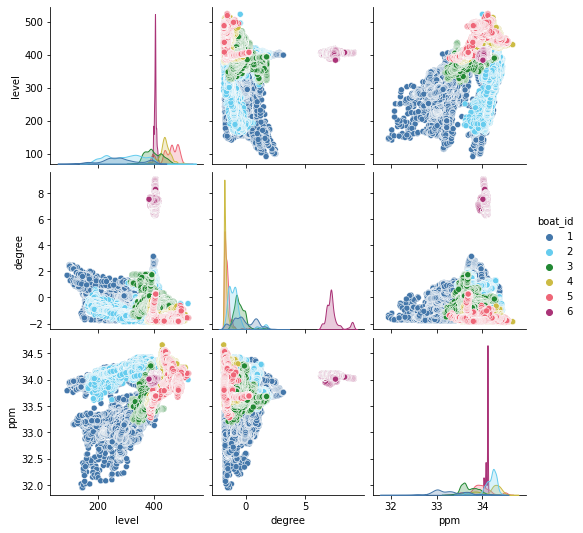

In [ ]:
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377']

sns.pairplot(
    data = df_wtr[['level', 'degree', 'ppm', 'boat_id']],
    hue='boat_id',
    palette=sns.color_palette(colors)
)


What trends do you see between features?

Do there appear to be correlations between level, ppm, and degree?

In [ ]:
corr = df_wtr[['level', 'degree', 'ppm', 'boat_id']].corr()
corr.style.background_gradient(cmap='coolwarm')

,level,degree,ppm,boat_id
level,1.000000,0.040953,0.308050,0.701517
degree,0.040953,1.000000,0.085616,0.496839
ppm,0.308050,0.085616,1.000000,0.369400
boat_id,0.701517,0.496839,0.369400,1.000000


Which features have the strongest correlations?  Which features have the weakest?

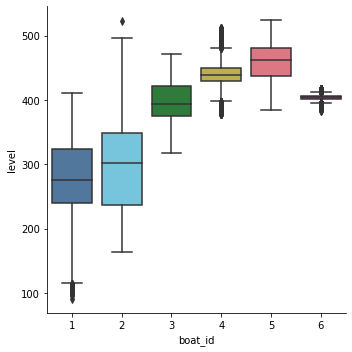

In [ ]:
sns.catplot(
    data=df_wtr,
    x='boat_id',
    y='level',
    palette=colors,
    kind='box',
)

## Modeling

Let's create a simple linear regression model that relates ppm and level.

In [ ]:
df_wtr['boat_id'] = df_wtr.boat_id.astype(str)
model = ols('level ~ ppm + boat_id', data=df_wtr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  level   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 2.439e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:19:08   Log-Likelihood:            -2.7144e+05
No. Observations:               52750   AIC:                         5.429e+05
Df Residuals:                   52743   BIC:                         5.430e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1983.3040     26.834    -73.911      0.000   -2035.898   -1930.710
boat_id[T.2]   -43.5077      0.938    -46.381      0.000     -45.346     -41.669
boat_id[T.3]    89.0583      0.746    119.363      0.000      87.596      90.521
boat_id[T.4]    99.7417      0.968    103.077      0.000      97.845     101.638
boat_id[T.5]   129.4147      0.839    154.180      0.000     127.770     131.060
boat_id[T.6]    68.8118      0.942     73.029      0.000      66.965      70.659
ppm             68.0072      0.806     84.379      0.000      66.427      69.587
==============================================================================
Omnibus:                     3206.335   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14319.630
Skew:                          -0.071   Prob(JB):                         0.00
Kurtosis:                       5.549   Cond. No.                     5.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,level,lat,lon,boat_id,degree,ppm
count,52750.000000,52750.000000,52750.000000,52750.000000,52750.000000,52750.000000
mean,374.976645,-62.205207,-65.392398,3.424455,0.188337,33.917115
std,80.721964,3.867494,10.127180,1.653760,2.998117,0.370045
min,90.840000,-67.941000,-90.472000,1.000000,-1.890000,31.950000
25%,326.555000,-64.752000,-65.365000,2.000000,-1.610000,33.700000
50%,399.865000,-63.891000,-62.683000,3.000000,-0.980000,34.030000
75%,435.190000,-61.603000,-57.752000,5.000000,-0.090000,34.180000
max,523.600000,-50.061000,-54.961000,6.000000,9.060000,34.660000


<AxesSubplot:xlabel='ppm', ylabel='level'>

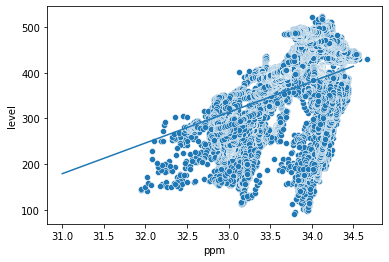

In [ ]:
predx = np.arange(31, 35, 0.5)
predy = predx * 67.1984 - 1904.1983

sns.scatterplot(data = df_wtr, x = 'ppm', y = 'level', palette = ['blue'])
sns.lineplot(x = predx, y = predy, palette = ['red'])

## Evaluating Goodness of Fit -- Checking Model Assumptions

* Independence Assumption
* Linearity / Mean Zero Assumption
* Constant Variance Assumption
* Normality Assumption

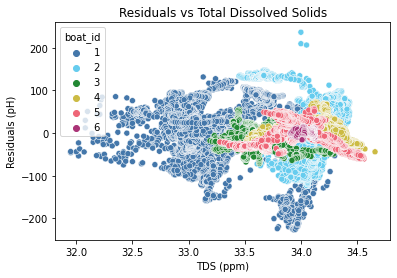

In [ ]:
g = sns.scatterplot(
    data=df_wtr,
    x='ppm',
    y=model.resid,
    hue='boat_id',
    palette=colors
).set(
    title='Residuals vs Total Dissolved Solids',
    xlabel='TDS (ppm)',
    ylabel='Residuals (pH)'
)

#### Checking Independence Assumption 

**Are the data independently pulled from the population?  You can't really check for this after the fact.  It should be built into the experiment from the beginning.**

There may be some clustering within the lower right group of data points, but it appears that the independence assumption may hold.


#### Checking Linearity / Mean Zero Assumption

**Do the approximately half the residuals lie above and below the zero line for randomly selected sections of the data?**

It appears that the linearity assumption holds.  About half the data points appear to lie on either side of the zero line.


#### Constant Variance Assumption

**Does the variance of the residuals appear to be the same throughout the residuals graph?**

The constant variance assumption may not hold because there appears to be coning with low variance at low ppm values, and higher variance at high ppm values.

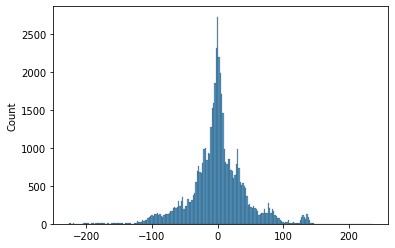

In [ ]:
g = sns.histplot(
    x = model.resid
)

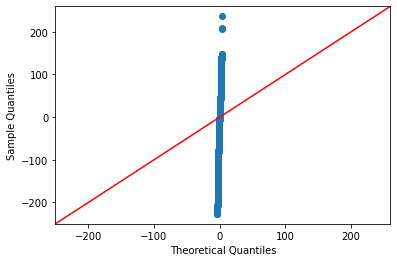

In [ ]:
g = sm.qqplot(
    model.resid,
    line='45'
)

In [ ]:
from scipy.stats import normaltest
z_score_stat, p_value = normaltest(model.resid)
print("Z-score statistic",z_score_stat)
print("p-value",p_value)

Z-score statistic 3206.335394528767
p-value 0.0


#### Normality Assumption

**Do the residuals appear to come from a normal distribution?**

Both the Q-Q Plot and the normality test suggest that the residuals are not pulled from a normal distribution, and the normality assumption may not hold.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad7152cb-d6c4-47fc-bce4-a1bd5240d55e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>